In [0]:
# author: Asmaa ~ 2019
# ----------------------

# import libraries
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Data Preparation

### Loading Data

In [1]:
# Doenload data
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2019-08-17 10:03:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  78.7MB/s    in 0.8s    

2019-08-17 10:03:10 (78.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# extract zip files

zip_ref = zipfile.ZipFile('//tmp/cats_and_dogs_filtered.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# splitting data
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# training cat pictures directory
train_cats_dir = os.path.join(train_dir, 'cats')

# training dog pictures directory
train_dogs_dir = os.path.join(train_dir, 'dogs')

# validation cat pictures directory
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# validation dog pictures directory
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# list of training images
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

### Pre-processing

In [0]:
# image augmentation for training set
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                   horizontal_flip = True)

# only scaling for test images
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [11]:
# flow data from training directory
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, 
                                                    class_mode = 'binary', target_size = (150, 150))     

# flow data from training directory
validation_generator =  test_datagen.flow_from_directory( validation_dir, batch_size  = 20,
                                                          class_mode  = 'binary', target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Building the Model

### Downloading Pre-trained Model (Inception)

In [13]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-08-17 10:12:41--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  65.5MB/s    in 1.3s    

2019-08-17 10:12:42 (65.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [15]:
weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = None)
pre_trained.load_weights(weights_file)

W0817 10:20:31.205200 140199317878656 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Re-structuring the Model 

In [18]:
# lock trainable layers to re-train
for layer in pre_trained.layers:
  layer.trainable = False


# get info about the model  
pre_trained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
# start re-training from 'mixed7' layer or any layer you prefer
last_layer = pre_trained.get_layer('mixed7')

# get info about output shape
print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


### Adding Our Own Layers

In [0]:
# flatten output layer to 1 dimension
x = layers.Flatten()(last_output)

# add a hidden layer with 1024 units
x = layers.Dense(1024, activation='relu')(x)

# add drop out rate
x = layers.Dropout(0.2)(x)

# add output layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# add layers to the model
model = Model( pre_trained.input, x) 

# compile the model
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])


### Training

In [26]:
fitting = model.fit_generator( train_generator, validation_data = validation_generator,
            steps_per_epoch = 100, epochs = 20, validation_steps = 50, verbose = 2)

Epoch 1/20
100/100 - 24s - loss: 0.4889 - acc: 0.7655 - val_loss: 0.1592 - val_acc: 0.9500
Epoch 2/20
100/100 - 17s - loss: 0.3764 - acc: 0.8250 - val_loss: 0.3956 - val_acc: 0.9120
Epoch 3/20
100/100 - 17s - loss: 0.3363 - acc: 0.8570 - val_loss: 0.2276 - val_acc: 0.9490
Epoch 4/20
100/100 - 17s - loss: 0.3441 - acc: 0.8515 - val_loss: 0.2715 - val_acc: 0.9520
Epoch 5/20
100/100 - 17s - loss: 0.3224 - acc: 0.8565 - val_loss: 0.4222 - val_acc: 0.9310
Epoch 6/20
100/100 - 17s - loss: 0.3241 - acc: 0.8575 - val_loss: 0.2674 - val_acc: 0.9540
Epoch 7/20
100/100 - 17s - loss: 0.2795 - acc: 0.8865 - val_loss: 0.2741 - val_acc: 0.9570
Epoch 8/20
100/100 - 17s - loss: 0.3150 - acc: 0.8760 - val_loss: 0.4670 - val_acc: 0.9350
Epoch 9/20
100/100 - 17s - loss: 0.2829 - acc: 0.8880 - val_loss: 0.2948 - val_acc: 0.9600
Epoch 10/20
100/100 - 17s - loss: 0.2526 - acc: 0.8965 - val_loss: 0.2912 - val_acc: 0.9590
Epoch 11/20
100/100 - 17s - loss: 0.2758 - acc: 0.8850 - val_loss: 0.3480 - val_acc: 0.95

# Visualizing Model Metrics

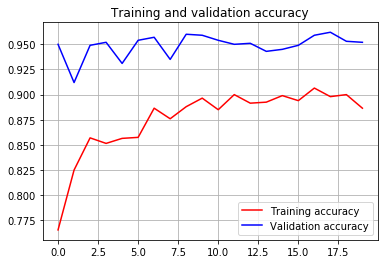

<Figure size 432x288 with 0 Axes>

In [33]:
# get parameters
acc = fitting.history['acc']
val_acc = fitting.history['val_acc']
loss = fitting.history['loss']
val_loss = fitting.history['val_loss']

epochs = range(len(acc))

# plot results
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()
plt.figure()

plt.show()